<a href="https://colab.research.google.com/github/aulphin/D-rise/blob/main/mainly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Fold

/content/drive/MyDrive/Colab Notebooks/Fold


In [ ]:
# # to execute py file
#!python rap.py

"""Method for generating saliency maps for object detection models."""


In [3]:
import base64
from io import BytesIO
from typing import Optional, Tuple
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import requests
import torch
import torchvision
from PIL import Image
from torchvision import transforms as T
from torchvision.models import detection

In [4]:
import visualization as viz
#from image_model_wrapper import (MLflowDRiseWrapper,PytorchDRiseWrapper)
from rap import (PytorchDRiseWrapper)
import drise

In [5]:
IMAGE_TYPE = ".jpg"

In [38]:
coco_classes = [
    "U","person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush","A","B","C","D","E","F","G","H","I","J","K"]

In [25]:
def get_drise_saliency_map(imagelocation: str,model: Optional[object],numclasses: int,
        savename: Optional[str]=None,nummasks: int = 200,maskres: Tuple[int, int] = (4, 4),
        maskpadding: Optional[int] = None,devicechoice: Optional[str] = None,max_figures: Optional[int] = None):

  if not devicechoice:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  else:
        device = devicechoice
  if not model:
        unwrapped_model = detection.fasterrcnn_resnet50_fpn(pretrained=True, map_location=device)
        unwrapped_model.to(device)
        model = PytorchDRiseWrapper(unwrapped_model, numclasses)
  image_open_pointer = imagelocation

  test_image = Image.open(image_open_pointer).convert('RGB')


  img_input = test_image
  if hasattr(model, "transforms") and model.transforms is not None:
      img_input = model.transforms(img_input)
  if not torch.is_tensor(img_input):
      img_input = T.ToTensor()(img_input)
  img_input = img_input.unsqueeze(0).to(device)
  detections = model.predict(img_input)

  saliency_scores = drise.DRISE_saliency( model=model,image_tensor=img_input, target_detections=detections,
            number_of_masks=nummasks, mask_padding=maskpadding,device=device,mask_res=maskres,verbose=True)

  img_index = 0
  # Filter out saliency scores containing nan values
  saliency_scores = [saliency_scores[img_index][i]
                     for i in range(len(saliency_scores[img_index]))
                     if not torch.isnan(saliency_scores[img_index][i]['detection']).any()]
  num_detections = len(saliency_scores)
  if num_detections == 0:
    raise ValueError("No detections found")


  label_list = []
  fig_list = []
  processed_labels = set()  # Keep track of processed labels
  if max_figures is None:
    loop_limit = num_detections
  else:
    loop_limit = min(num_detections, max_figures)

  for i in range(loop_limit):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    label = int(torch.argmax(detections[img_index].class_scores[i]))
    label_name = coco_classes[label]  # Get the label name from coco_classes

     # Check if this label has already been processed
    if label in processed_labels:
        continue  # Skip processing this label again
    else:
        processed_labels.add(label)  # Mark this label as processed
    label_list.append(label)
    viz.visualize_image_attr(numpy.transpose(saliency_scores[i]['detection'].cpu().detach().numpy(),(1, 2, 0)),
               numpy.transpose(T.ToTensor()(test_image).numpy(), (1, 2, 0)),method="blended_heat_map",
               sign="positive",show_colorbar=False,cmap='jet',title=f"Saliency {i} - Class {label} {label_name} ")

    stream = BytesIO()
    plt.savefig(stream, format='jpg')
    stream.seek(0)
    b64_string = base64.b64encode(stream.read()).decode()
    fig_list.append(b64_string)
    #fig.clear()
  return fig_list, label_list


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:00<00:00, 2228.30it/s]


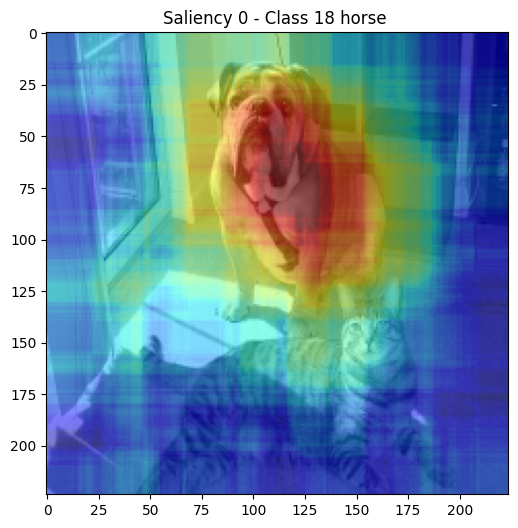

<Figure size 640x480 with 0 Axes>

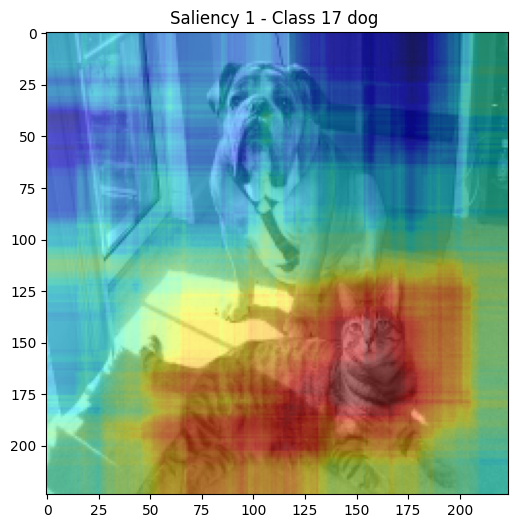

<Figure size 640x480 with 0 Axes>

In [33]:
# calling the function
figures,labels = get_drise_saliency_map(imagelocation="catdog.png", model=None, numclasses=91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:00<00:00, 2926.34it/s]


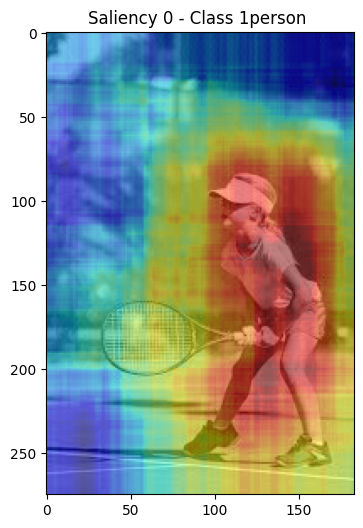

<Figure size 640x480 with 0 Axes>

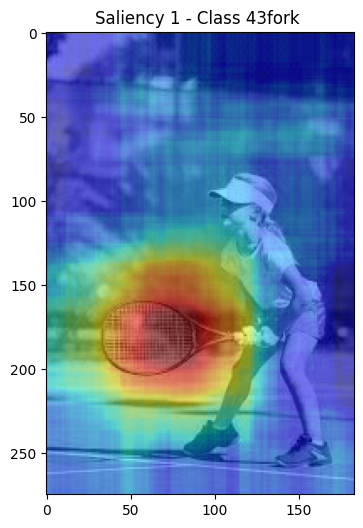

<Figure size 640x480 with 0 Axes>

In [23]:
# calling the function
figures,labels = get_drise_saliency_map(imagelocation="girl.jpg", model=None, numclasses=91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:14<00:00, 13.91it/s]


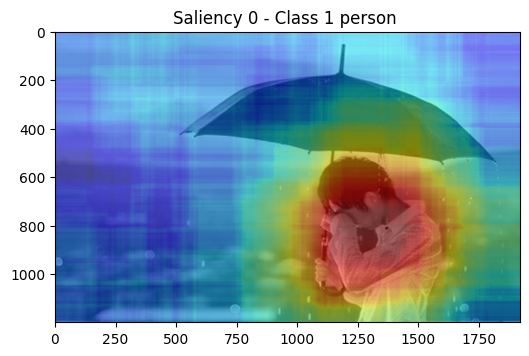

<Figure size 640x480 with 0 Axes>

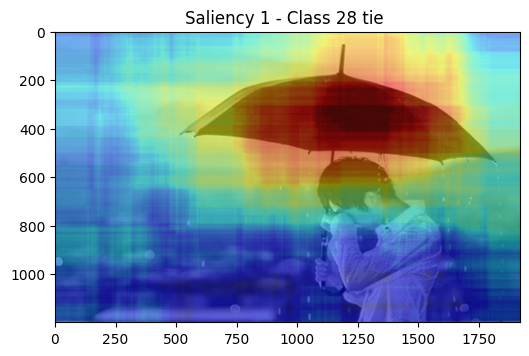

<Figure size 640x480 with 0 Axes>

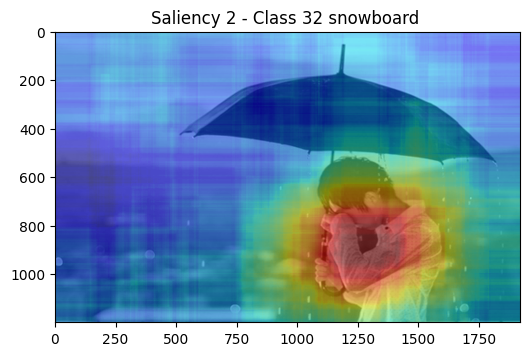

<Figure size 640x480 with 0 Axes>

In [32]:
# calling the function
figures,labels= get_drise_saliency_map(imagelocation="umbrel.jpg", model=None, numclasses=91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:00<00:00, 1702.60it/s]


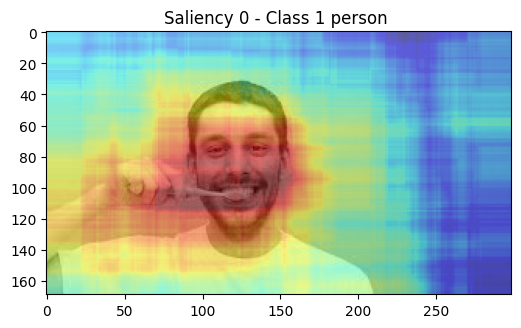

<Figure size 640x480 with 0 Axes>

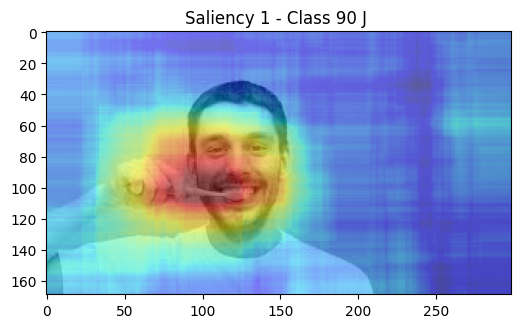

<Figure size 640x480 with 0 Axes>

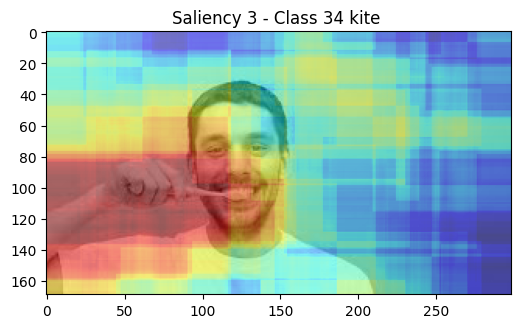

<Figure size 640x480 with 0 Axes>

In [39]:
# calling the function
figures,labels= get_drise_saliency_map(imagelocation="tooth.jpg", model=None, numclasses=91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:00<00:00, 3140.09it/s]


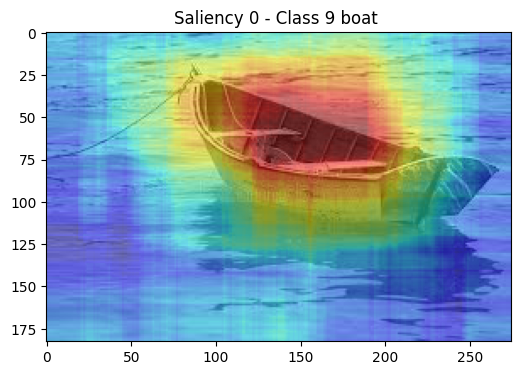

<Figure size 640x480 with 0 Axes>

In [30]:
# calling the function
figures,labels= get_drise_saliency_map(imagelocation="boat.jpg", model=None, numclasses=91)

100%|██████████| 199/199 [00:00<00:00, 2503.64it/s]


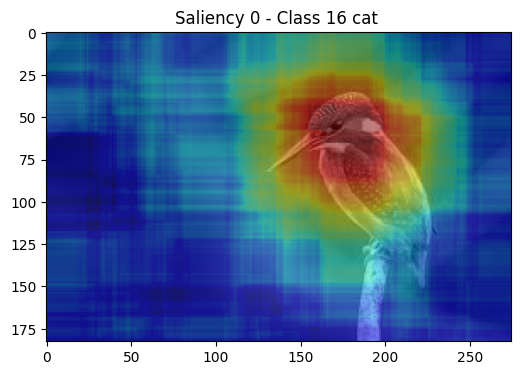

<Figure size 640x480 with 0 Axes>

In [41]:
# calling the function
figures,labels= get_drise_saliency_map(imagelocation="bird.jpg", model=None, numclasses=90)